In [2]:
import torch # import the PyTorch module
import torch.nn as nn # import the nn (neural network) module from PyTorch
import torch.optim as optim # import the optim (optimization) module from PyTorch
from torch.autograd import Variable # import the Variable module from PyTorch
from torchvision import datasets, models, transforms # import the datasets, models, transforms modules from PyTorch
import os # import the os module
from sklearn.metrics import confusion_matrix # import the confusion_matrix for evaluation
from sklearn.metrics import f1_score # import the f1_score for evaluation
import plotly.express as px # import the plotly.express module for data visualization
from skimage import io # import the skimage.io module for data visualization
import plotly.graph_objects as go # import the plotly.graph_objects module for data visualization
import plotly.figure_factory as ff # import the plotly.figure_factory module for data visualization
from tqdm import tqdm # module to show the progress bar
from IPython.display import Image, display # module to show the image


v1_dataset = 'covid/' # dataset directory
v2_learning_rate=0.001 # Learning rate hyperparameter for the optimizer
v3_momentum=0.9 # Momentum hyperparameter for the optimizer
v4_n_epochs = 2 # Number of epochs/iterations for training
v5_criterion = nn.CrossEntropyLoss() # Loss function
v6_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Device for training, if cuda is available then run on GPU else run on CPU


# Creating training, validation and test data
def create_data(path):
  '''
  - Resizing image, converting to tensor and normalizing -> these transforms are applied to training, validation and test data so we can have consistent data for training and for predictions
  - In PyTorch, a tensor for images is like a container that holds image data. It's a multi-dimensional array that can represent the pixel values and structure of an image. Think of it as a versatile data structure that makes it easy to perform operations on images, such as resizing, transforming, and feeding them into neural networks for tasks like image classification or object detection
  - Resizing, rotating, cropping, and flipping is applied to training data only to increase the size of the dataset (data augmentation), to avoid overfitting, and to improve model generality so it can learn features from other images in a better way
  '''
  train_transforms = transforms.Compose([ 
                                        transforms.RandomRotation(30),
                                        transforms.Resize(224),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.252, 0.293, 0.288],
                                                              [0.146, 0.191, 0.193])])

  test_transforms = transforms.Compose([
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.252, 0.293, 0.288],
                                                              [0.146, 0.191, 0.193])])

  valid_transforms = transforms.Compose([
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.252, 0.293, 0.288],
                                                              [0.146, 0.191, 0.193])])

  # reading train, test, and validation folders and applying transforms
  train_data = datasets.ImageFolder(path + '/train', transform=train_transforms)
  valid_data = datasets.ImageFolder(path + '/validation', transform=valid_transforms)
  test_data = datasets.ImageFolder(path + '/test', transform=test_transforms)

  # creating data loaders of PyTorch for training, validation and test from above transforms that will be used for training
  # shuffle=True is used to shuffle the data, batch_size=12 is used to set the batch size that means we will take 12 images at a time
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=12, shuffle=True)
  validloader = torch.utils.data.DataLoader(valid_data, batch_size=12, shuffle=True)
  testloader = torch.utils.data.DataLoader(test_data, batch_size=12, shuffle=True)

  # displaying the classes in our data that are represented by separate folders in train, validation and test. 
  print("Classes: ")
  class_names = train_data.classes
  print(class_names)
  
  # returing the data loaders and class names
  return trainloader,validloader,testloader,class_names


# Plotting loss of training and validation
def plot_loss(tloss, vloss):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=[i for i in range(len(tloss))],y=tloss,name="Training loss",mode='lines'))
  fig.add_trace(go.Scatter(x=[i for i in range(len(vloss))],y=vloss,name="Validation loss",mode='lines'))
  fig.update_layout(title="Loss curves",xaxis_title="epochs",yaxis_title="loss")
  # fig.show()
  fig.write_image ('loss.jpg')
  display(Image (data = 'loss.jpg', width = 1000))

# Plotting accuracy of training and validation
def plot_Accuracy(tacc, vacc):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=[i for i in range(len(tacc))],y=tacc,name="Training accuracy",mode='lines'))
  fig.add_trace(go.Scatter(x=[i for i in range(len(vacc))],y=vacc,name="Validation accuracy",mode='lines'))
  fig.update_layout(title="Accuracy curves",xaxis_title="epochs",yaxis_title="accuracy")
  # fig.show()
  fig.write_image ('accuracy.jpg')
  display(Image (data = 'accuracy.jpg', width = 1000))


# plot confusion matrix that will show the number of correct and incorrect predictions for each class
def plot_ConfusionMatrix(confusion_matrix,class_names, title):
  z = confusion_matrix.astype(int)
  x = class_names
  y = class_names
  # change each element of z to type string for annotations
  z_text = [[str(y) for y in x] for x in z]
  # set up figure 
  fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
  # add title
  
  fig.update_layout(title_text='<i><b>'+title + ' Confusion matrix</b></i>')
  # add custom xaxis title
  fig.add_annotation(dict(font=dict(color="black",size=14),x=0.5,y=-0.15,showarrow=False,text="Predicted value",xref="paper",yref="paper"))
  # add custom yaxis title
  fig.add_annotation(dict(font=dict(color="black",size=14),x=-0.35,y=0.5,showarrow=False,text="Real value",textangle=-90,xref="paper",yref="paper"))
  # adjust margins to make room for yaxis title
  fig.update_layout(margin=dict(t=50, l=200))
  # fig.show()
  fig.write_image ('confusion_matrix.jpg')
  display(Image (data = 'confusion_matrix.jpg', width = 1000))


# Visualizing the image
def Show_dataSamples(path,class_names,n):
  Infected = os.listdir(path + 'validation/'+ class_names[0]+'/')
  Normal = os.listdir(path + 'validation/'+ class_names[1]+'/')
  img = io.imread(path + 'validation/'+ class_names[0]+'/'+Infected[n])
  fig = px.imshow(img,color_continuous_scale='gray', title=class_names[0])
  # fig.show()
  fig.write_image ('sample.jpg')
  display(Image (data = 'sample.jpg', width = 1000))
  img = io.imread(path + 'validation/'+ class_names[1]+'/'+Normal[n])
  fig = px.imshow(img,color_continuous_scale='gray', title=class_names[1])
  # fig.show()
  fig.write_image ('sample.jpg')
  display(Image (data = 'sample.jpg', width = 1000))


# Showing the distribution of data with bar chart
def ShowDataSetSize(path,class_names, title):
  subfolders=['test','train','validation']
  testInf=len(os.listdir(path+'/'+subfolders[0]+'/'+class_names[0]))
  testNor=len(os.listdir(path+'/'+subfolders[0]+'/'+class_names[1]))
  trainInfected = len(os.listdir(path+'/'+subfolders[1]+'/'+class_names[0]))
  trainNormal = len(os.listdir(path+'/'+subfolders[1]+'/'+class_names[1]))
  valInf=len(os.listdir(path+'/'+subfolders[2]+'/'+class_names[0]))
  valNor=len(os.listdir(path+'/'+subfolders[2]+'/'+class_names[1]))
  fig = go.Figure(data=[
    go.Bar(name=class_names[0], x=subfolders, y=[testInf, trainInfected, valInf]),
    go.Bar(name=class_names[1], x=subfolders, y=[testNor, trainNormal, valNor])
  ])
  fig.update_layout(barmode='group', title= title)
  # fig.show()
  fig.write_image ('dataset_distribution.jpg')
  display(Image(data = 'dataset_distribution.jpg', width = 1000))


# Plotting the prediction vs true values
def plot_prediction_comparison(pred_a,pred_b,tit):
  fig = go.Figure()
  lmin = min(min(pred_a), min(pred_b))
  lmax = max(max(pred_a), max(pred_b))
  lims = [lmin, lmax]
  fig.add_trace(go.Scatter(x=pred_a, y=pred_b,
                    mode='markers',
                    name='data points'))
  fig.add_trace(go.Scatter(x=lims, y=lims,
                    mode='lines',
                    name='limit line'))
  fig.update_layout(title=tit,xaxis_title="'True Values [Y]'",yaxis_title='Predictions [Y]')  
  # fig.show()
  fig.write_image ('prediction_comparison.jpg')
  display(Image (data = 'prediction_comparison.jpg', width = 1000))


# Define a function named 'getAccuracy' that takes 'givenData' as input.
def getAccuracy(givenData, resnet18):
  # Initialize variables to keep track of correct predictions and the total number of predictions.
  correct = 0
  total = 0
  # Create empty lists to store the true labels (tl) and predicted labels (pr).
  pr =[]
  tl =[]
  with torch.no_grad(): # Use 'torch.no_grad()' to disable gradient computation as we don't need it for inference.
    for data in givenData: # Iterate through the data in 'givenData'.
      images, labels = data # Unpack 'images' and 'labels' from the current batch of data.
      images, labels = images.to(v6_device), labels.to(v6_device) # Move 'images' and 'labels' to the computing device (CPU or GPU).
      outputs = resnet18(images) # Pass the 'images' through the 'resnet18' model to get predictions ('outputs').
      _, predicted = torch.max(outputs.data, 1) # Find the index of the maximum predicted value for each image.
      total += labels.size(0) # Update the 'total' count by adding the number of labels in the current batch.
      correct += (predicted == labels).sum().item() # Update the 'correct' count by adding the number of correctly predicted labels in the current batch.
      loss = v5_criterion(outputs, labels) # Calculate the loss using 'v5_criterion'.
      acc = (100 * correct / total) # Calculate the accuracy (in percentage) based on the current counts.
      # Append true labels to 'tl' list.
      for i in labels.tolist():
        tl.append(i)
      # Append predicted labels to 'pr' list.
      for j in predicted.tolist():
        pr.append(j)
  # Return accuracy (acc), loss (loss.item()), true labels (tl), and predicted labels (pr).  
  return acc, loss.item(), tl, pr


'''
- function that will be called before training process
- show images of x-rays
- show distribution of data
'''
def plot_data_before_training(v1_dataset, class_names):
  # Showing Input Images
  for i in range(2):
    Show_dataSamples(v1_dataset,class_names,i)
  # Shaowing Data Distribution
  ShowDataSetSize(v1_dataset,class_names, 'Dataset Distribution')


# Define a function to get a pretrained ResNet-18 model with modified fully connected layers for a image classification problem.
def get_pretrained_model():
    # Load the ResNet-18 model pretrained on a large dataset (e.g., ImageNet).
    resnet18 = models.resnet18(pretrained=True)
    
    # Define new fully connected layers for the model. These layers will replace the original classification layer.
    new_fc_resnet = [
        nn.Linear(512, 370),            # Linear layer with 512 input features and 370 output features.
        nn.ReLU(inplace=True),          # Activation function (ReLU) applied in-place.
        nn.Dropout(p=0.5, inplace=False),  # Dropout layer with a dropout probability of 0.5.
        nn.Linear(370, 2)               # Linear layer with 370 input features and 2 output features.
    ]
    
    # Replace the original classification layer of ResNet-18 with the new layers.
    resnet18.fc = nn.Sequential(*new_fc_resnet)
    
    # Freeze certain layers to prevent their weights from being updated during training.
    # This is useful when you want to fine-tune only the newly added layers.
    for param in resnet18.parameters():
        param.requires_grad = False  # Freeze all parameters by default.
    for param in resnet18.fc.parameters():
        param.requires_grad = True    # Unfreeze the parameters of the new fully connected layers.
    for param in resnet18.layer1.parameters():
        param.requires_grad = True    # Unfreeze the parameters of layer1.
    for param in resnet18.layer2.parameters():
        param.requires_grad = True    # Unfreeze the parameters of layer2.
    
    return resnet18  # Return the modified ResNet-18 model.
  


# Define a function for training a resnet18 machine learning model.
def train_model(trainloader, validloader, resnet18):
  # Define the optimization algorithm (Stochastic Gradient Descent) with learning rate and momentum.
  optimizer = optim.SGD(resnet18.parameters(), lr=v2_learning_rate, momentum=v3_momentum)
  
  # Move the model to the GPU if available.
  resnet18.to(v6_device)
  
  # Set the model to training mode.
  resnet18.train()
  
  # Initialize lists to store training and validation accuracy, as well as loss.
  trainAccuracy =[]
  validAccuracy = []
  TrainLoss =[]
  ValidLoss=[]
  
  # Loop over the dataset for a specified number of epochs.
  for epoch in range(1, v4_n_epochs+1):
    running_loss = 0.0
    
    # Create a progress bar to monitor training progress.
    pbar = tqdm(enumerate(trainloader))
    
    # Loop over batches of data.
    for i, data in pbar:
      # Get the inputs and labels.
      inputs, labels = data
      
      # Move inputs and labels to the GPU.
      inputs, labels = inputs.to(v6_device), labels.to(v6_device)

      # Zero the gradients.
      optimizer.zero_grad()
      
      # Forward pass: compute model predictions.
      outputs = resnet18(inputs)
      
      # Compute the loss between predictions and actual labels.
      loss = v5_criterion(outputs, labels)
      
      # Backpropagation: compute gradients.
      loss.backward()
      
      # Update model parameters using the optimizer.
      optimizer.step()

      # Update the running loss for this epoch.
      running_loss += loss.item()
      
      # Update the progress bar description.
      pbar.set_description(
          'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, i * len(inputs), len(trainloader.dataset),
              100. * i / len(trainloader),
              loss.item()))

    # Save the model's state dictionary to a file.
    torch.save(resnet18.state_dict(), 'resnet18/res18.pth')
    
    # Get training accuracy and loss using a helper function.
    tacc, tloss, train_tl,train_pr = getAccuracy(trainloader, resnet18)
    
    # Store training accuracy and loss in lists.
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    
    # Get validation accuracy and loss using a helper function.
    vacc , vloss, val_tl, val_pr = getAccuracy(validloader, resnet18)
    
    # Store validation accuracy and loss in lists.
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
  
  # Save the entire model.
  torch.save(resnet18, "trained_model.pt")

  # Plot training and validation loss.
  plot_loss(TrainLoss, ValidLoss)
  
  # Plot training and validation accuracy.
  plot_Accuracy(trainAccuracy,validAccuracy)
  
  # Calculate and print training and validation F1 scores.
  print("\ntraining f1_score",f1_score(train_tl,train_pr))
  print("validation f1_score",f1_score(val_tl,val_pr)) 
  
  # Print a message indicating that training has finished.
  print('\nFinished Training')
  
  # Return training and validation true labels and predicted labels.
  return train_tl,train_pr,val_tl,val_pr



def predict_model(testloader, class_names, resnet18):
  # Initialize variables to keep track of correct predictions and total data points
  correct = 0
  total = 0

  # Create empty lists to store true labels (tl) and predicted labels (pr)
  tl = []
  pr = []

  # Disable gradient computation since we're only predicting
  with torch.no_grad():
      # Loop through the data in the testloader
      for data in testloader:
          # Get images and their true labels
          images, labels = data
          
          # Move images and labels to the appropriate device (CPU or GPU)
          images, labels = images.to(v6_device), labels.to(v6_device)
          
          # Feed the images through the neural network (resnet18)
          outputs = resnet18(images)
          
          # Get the index of the highest predicted value for each image
          _, predicted = torch.max(outputs.data, 1)
          
          # Count the total number of images
          total += labels.size(0)
          
          # Count the number of correct predictions
          correct += (predicted == labels).sum().item()
          
          # Append true labels to the tl list
          for i in labels.tolist():
              tl.append(i)
          
          # Append predicted labels to the pr list
          for j in predicted.tolist():
              pr.append(j)

      # Calculate and plot the confusion matrix
      plot_ConfusionMatrix(confusion_matrix(tl, pr), class_names, 'Test')
      
      # Calculate and print the F1 score
      print("f1_score", f1_score(tl, pr))

  # Calculate and print the accuracy of the network on test images
  print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

# Plot Data after training
def plot_data_after_training(train_tl,train_pr,val_tl,val_pr, class_names):
  plot_ConfusionMatrix(confusion_matrix(train_tl,train_pr),class_names,'Training')
  plot_ConfusionMatrix(confusion_matrix(val_tl,val_pr),class_names,'Validation')



In [3]:
trainloader,validloader,testloader,class_names= create_data(v1_dataset)

Classes: 
['infected', 'normal']


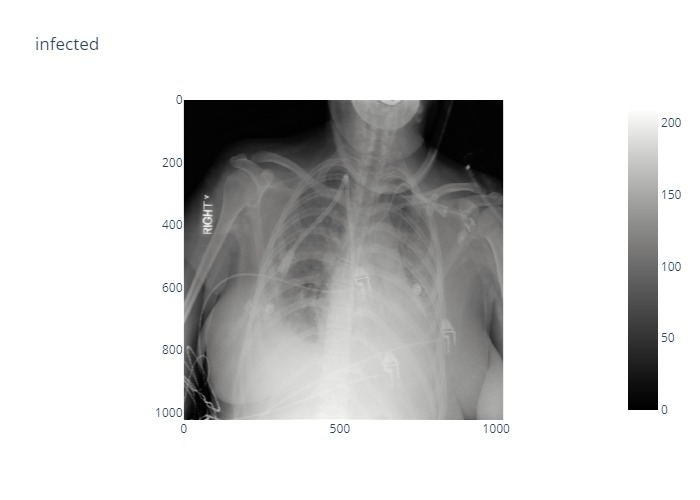

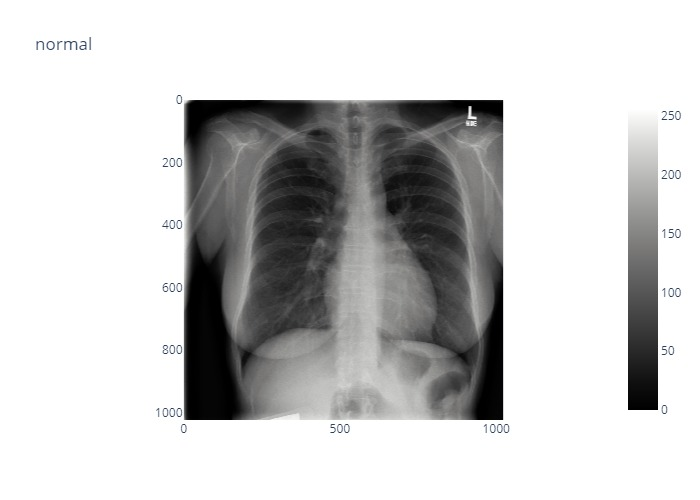

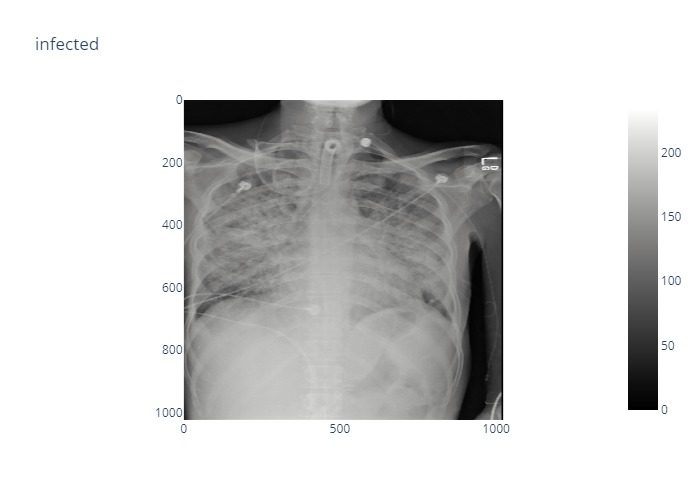

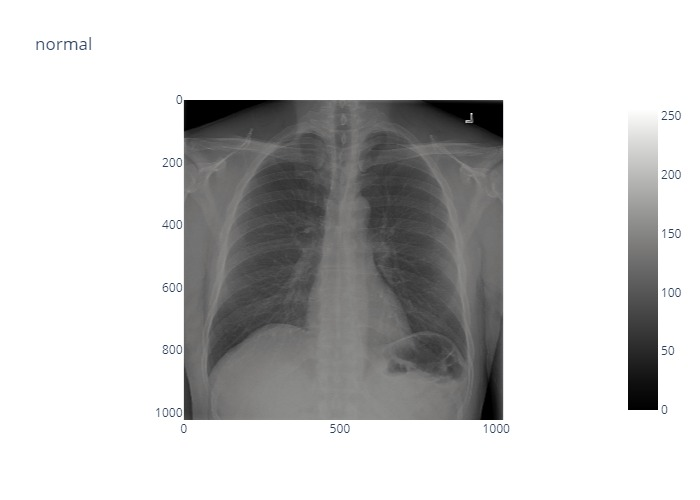

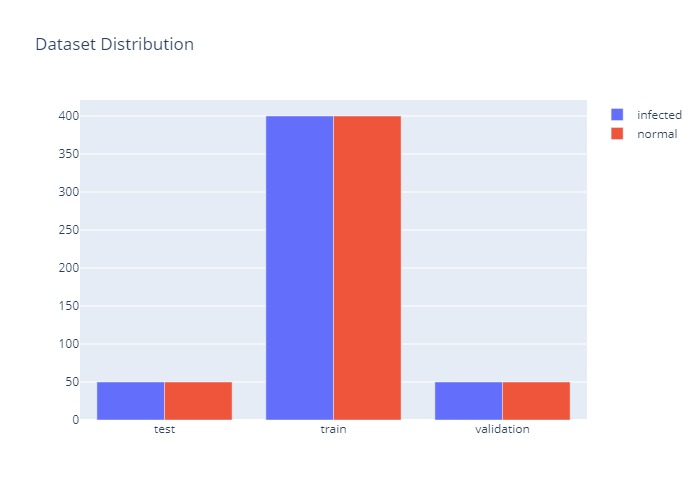

In [4]:
# Plot data Before Training
plot_data_before_training(v1_dataset, class_names)

In [4]:
# Pretained Model
resnet18 = get_pretrained_model()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Train model
train_tl,train_pr,val_tl,val_pr = train_model(trainloader, validloader, resnet18)

Train Epoch: 1 [528/800 (99%)]	Loss: 0.485747: : 67it [06:45,  6.05s/it]
Train Epoch: 2 [528/800 (99%)]	Loss: 0.564868: : 67it [11:24, 10.21s/it]



training f1_score 0.8072445019404917
validation f1_score 0.8865979381443299

Finished Training


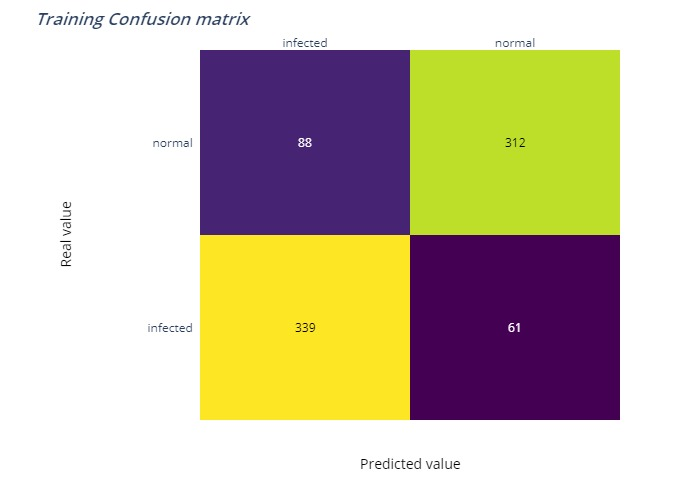

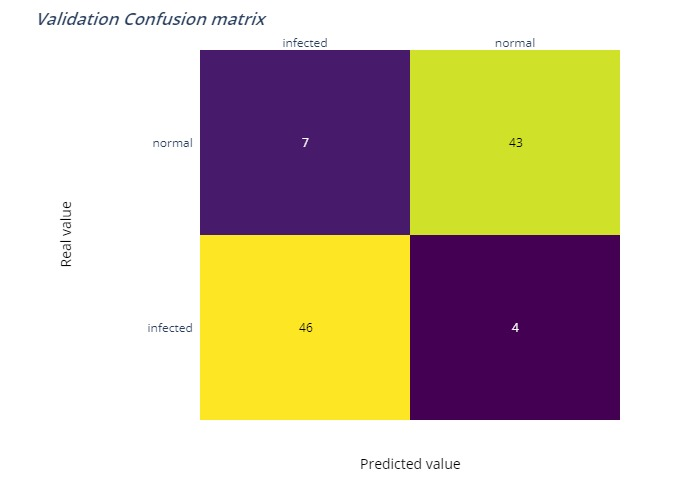

In [34]:
# Plot Data After Training
plot_data_after_training(train_tl,train_pr,val_tl,val_pr, class_names)

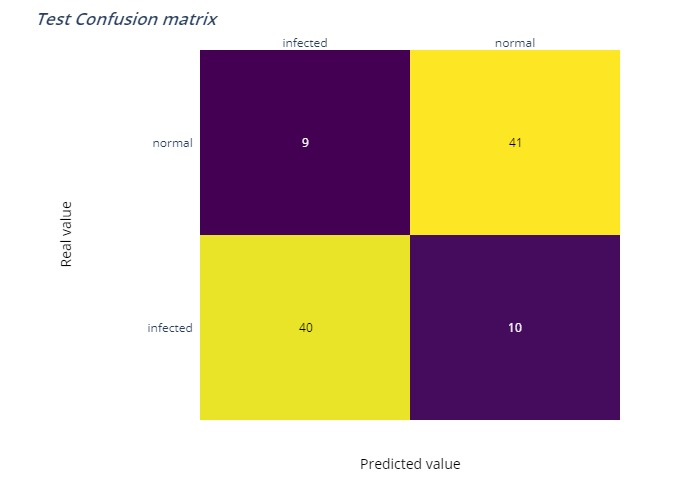

f1_score 0.8118811881188118
Accuracy of the network on test images: 81 %


In [35]:
# Prediction on test Data
predict_model(testloader, class_names, resnet18)

tensor([[0.4383, 0.1718]], grad_fn=<AddmmBackward>)
infected


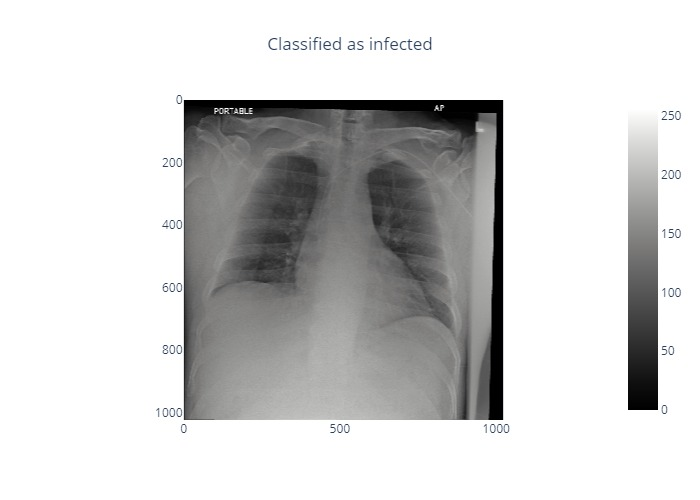

tensor([[-0.7952,  1.5185]], grad_fn=<AddmmBackward>)
normal


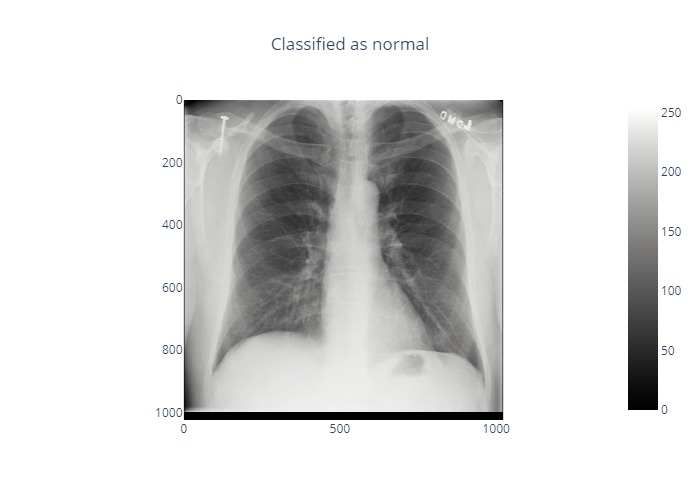

In [29]:
# Predictions on single image or directory of images
from PIL import Image # PIL is Python Imaging Library, used for image processing
import IPython
from IPython.display import display

# Define a series of image transformations to be applied to each loaded image same as done for training images
loader = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Lambda(lambda x: x.repeat(3,1,1)),
                                      transforms.Normalize([0.252, 0.293, 0.288],
                                                           [0.146, 0.191, 0.193])
                                                                                 ])
# Define a function to load an image and preprocess it and converts to tensor required to perform predictions
def image_loader(image_name):
    """Load an image and return it as a CUDA tensor (assumes GPU usage)"""
    image = Image.open(image_name)  # Open the image file
    image = loader(image).float()  # Apply the defined transformations to the image
    image = Variable(image, requires_grad=True)  # Create a PyTorch variable with gradients enabled
    image = image.unsqueeze(0)  # Reshape the image tensor (not necessary for ResNet)
    return image  # Return the preprocessed image tensor


# Specify the path to the directory containing the images you want to classify
image_path = "predictions/"

# Define class names for the possible image classifications
class_names = ["infected", "normal"]

# Load the pre-trained model from the 'trained_model.pt' file (using CPU)
model = torch.load('trained_model.pt', map_location="cpu")

# Set the model to evaluation mode
model.eval()

# from IPython.display import Image # module to show the image
# List all image files in the specified directory
images = os.listdir(image_path)

# Loop through each image and perform predictions
for i in images:
    image = image_loader(image_path + i)  # Load and preprocess the image
    output = model(image)  # Perform a prediction using the loaded model
    print(output)
    index = output.data.cpu().numpy().argmax()  # Get the index of the predicted class
    print(class_names[index])  # Print the class name that the image was classified as

    img = io.imread(image_path + i)  # Read the original image
    # Create an interactive visualization of the image with classification label
    fig = px.imshow(img, color_continuous_scale='gray', title="Classified as " + class_names[index])
    fig.update_layout(title_x=0.5)
    # fig.show()  # Display the visualization
    fig.write_image('predictions.jpg')
    display(IPython.display.Image(data = 'predictions.jpg', width = 1000))


In [1]:
!pip install streamlit

     ---------------------------------------- 7.6/7.6 MB 2.5 MB/s eta 0:00:00
  Using cached typing_extensions-4.8.0-py3-none-any.whl (31 kB)
  Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl (10.8 MB)
     ---------------------------------------- 4.8/4.8 MB 1.2 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.22.2 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.8.0 which is incompatible.
shapash 1.6.1 requires plotly==4.12.0, but you have plotly 5.11.0 which is incompatible.
You should consider upgrading via the 'C:\Program Files\Python38\python.exe -m pip install --upgrade pip' command.


  Using cached watchdog-3.0.0-py3-none-win_amd64.whl (82 kB)
     -------------------------------------- 430.5/430.5 KB 5.4 MB/s eta 0:00:00
     -------------------------------------- 520.6/520.6 KB 6.5 MB/s eta 0:00:00
     -------------------------------------- 239.8/239.8 KB 5.0 MB/s eta 0:00:00
     -------------------------------------- 190.0/190.0 KB 3.8 MB/s eta 0:00:00
  Using cached pyarrow-13.0.0-cp38-cp38-win_amd64.whl (24.4 MB)
  Using cached blinker-1.6.2-py3-none-any.whl (13 kB)
  Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)
  Using cached gitdb-4.0.10-py3-none-any.whl (62 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached Pygments-2.16.1-py3-none-any.whl (1.2 MB)
  Using cached backports.zoneinfo-0.2.1-cp38-cp38-win_amd64.whl (38 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
  Attempting uninstall: